In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import os
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [2]:
#helper functions for loading data (taken from code given in practicals)
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def load_data():
    return train_loader

In [3]:
#loading data (taken from code given in practicals)
data_dir = '/workspace/Data' 

dataset = torchvision.datasets.ImageFolder(root=data_dir,
                           transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((128,128)),
                               torchvision.transforms.ToTensor(),
                           ]))

train_loader = torch.utils.data.DataLoader(dataset, batch_size=6,
                                         shuffle=True, num_workers=2)

In [4]:
#initializing variables
device = 'cuda'
batch_size = 6
img_size = (128, 128) # (width, height)

input_dim = 3

n_embeddings= 1024 #code book vectors
output_dim = 3

lr = 2e-4

print_step = 50

In [5]:
#Blocks for vq-vae model. Code taken from https://github.com/dome272/VQGAN-pytorch
class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)#change num_groups to 32, since latent size is 16

    def forward(self, x):
        return self.gn(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)


class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A

In [6]:
#Encoder - code modified from https://github.com/dome272/VQGAN-pytorch
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        channels = [128, 128, 256, 256, 512]
        attn_resolutions = [16]
        num_res_blocks = 2
        resolution = 256
        layers = [nn.Conv2d(3, channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], 512, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
#codebook embedding layer - code modified from https://github.com/dome272/VQGAN-pytorch
class EMCodebook(nn.Module):
    def __init__(self):
        super(EMCodebook, self).__init__()
        self.num_codebook_vectors = n_embeddings
        self.latent_dim = 512
        self.beta = 0.25

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.latent_dim)

        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, min_encoding_indices, loss

In [9]:
#decoder - code modified from https://github.com/dome272/VQGAN-pytorch
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        channels = [512, 256, 256, 128]
        attn_resolutions = [16]
        num_res_blocks = 3
        resolution = 16

        in_channels = channels[0]
        layers = [nn.Conv2d(512, in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, 3, 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
#VQ-VAE class
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
    
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, codebook_indices, loss = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, codebook_indices, loss
    

In [31]:
#initialize vq-vae
encoder = Encoder()
codebook = EMCodebook()
decoder = Decoder()

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to('cuda')

In [32]:
#select loss and optimizer
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

In [33]:
#function to generate samples - code taken from https://github.com/rosinality/vq-vae-2-pytorch
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [34]:
#load previously trained vq-vae from checkpoint
state = torch.load('./vae/vae16.2_final_k_state_epoch_odd')

model.load_state_dict(state['vae_dict'])
optimizer.load_state_dict(state['optim'])

  0%|          | 0/11667 [00:00<?, ?it/s]


69
torch.Size([6, 3, 128, 128])


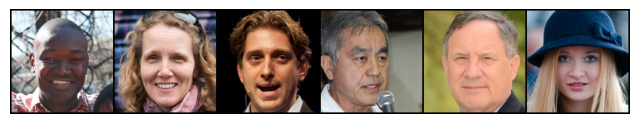

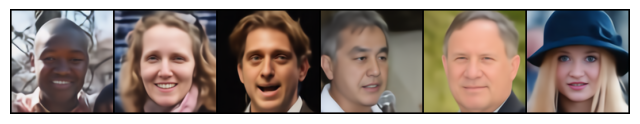

In [35]:
#draw sample reconstructions - code taken from https://github.com/rosinality/vq-vae-2-pytorch
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        print(state.get('epoch'))
        x = x.to(device)
#         x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        x_hat, indices, loss = model(x)
        print(x_hat.shape)
#         print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break
draw_sample_image(x[:batch_size], "Ground-truth images")
draw_sample_image(x_hat[:batch_size], "Reconstructed images")

In [ ]:
#set max epochs
epochs = 100

In [ ]:
#Training loop - code modified from https://github.com/rosinality/vq-vae-2-pytorch
print("Start training VQ-VAE...")
model.train()

# for epoch in range(0, epochs):
for epoch in range(state['epoch']+1, epochs):
    print('epoch: '+str(epoch))
    with tqdm(range(len(train_loader))) as pbar:
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()
            
            x_hat, _, loss = model(x)
            
            recon_loss = mse_loss(x_hat, x)
            
            loss = loss + recon_loss

            loss.backward()
            optimizer.step()
  
            pbar.set_postfix(
                recon_loss = np.round(recon_loss.cpu().detach().numpy().item(), 5),
                total_loss = np.round(loss.cpu().detach().numpy().item(), 5)
            )
            pbar.update(1)
            

#         draw_sample_image(x[:batch_size], "Ground-truth images")
#         draw_sample_image(x_hat[:batch_size], "Reconstructed images")
        if epoch%2==0:
            state = {
                'epoch': epoch,
                'vae_dict': model.state_dict(),
                'optim': optimizer.state_dict(),
                }
            torch.save(state, os.path.join("vae", "vae16.2_final_k_state_epoch_even"))
        elif epoch%2!=0:
            state = {
                'epoch': epoch,
                'vae_dict': model.state_dict(),
                'optim': optimizer.state_dict(),
                }
            torch.save(state, os.path.join("vae", "vae16.2_final_k_state_epoch_odd"))
        

print("Finish!!")
#6 saved states is max for storage

In [12]:
#mingpt implementation - taken from https://github.com/karpathy/minGPT/
import math

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k, v in kwargs.items():
            setattr(self, k, v)


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        mask = torch.tril(torch.ones(config.block_size,
                                     config.block_size))
        if hasattr(config, "n_unmasked"):
            mask[:config.n_unmasked, :config.n_unmasked] = 1
        self.register_buffer("mask", mask.view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        present = torch.stack((k, v))
        if layer_past is not None:
            past_key, past_value = layer_past
            k = torch.cat((past_key, k), dim=-2)
            v = torch.cat((past_value, v), dim=-2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if layer_past is None:
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y, present  # TODO: check that this does not break anything


class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),  # nice
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x, layer_past=None, return_present=False):
        # TODO: check that training still works
        if return_present:
            assert not self.training
        # layer past: tuple of length two with B, nh, T, hs
        attn, present = self.attn(self.ln1(x), layer_past=layer_past)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        if layer_past is not None or return_present:
            return x, present
        return x


class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, vocab_size, block_size, n_layer=12, n_head=8, n_embd=256,
                 embd_pdrop=0., resid_pdrop=0., attn_pdrop=0., n_unmasked=0):
        super().__init__()
        config = GPTConfig(vocab_size=vocab_size, block_size=block_size,
                           embd_pdrop=embd_pdrop, resid_pdrop=resid_pdrop, attn_pdrop=attn_pdrop,
                           n_layer=n_layer, n_head=n_head, n_embd=n_embd,
                           n_unmasked=n_unmasked)
        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))  # 512 x 1024
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)
        self.config = config

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, idx, embeddings=None):
        token_embeddings = self.tok_emb(idx)  # each index maps to a (learnable) vector

        if embeddings is not None:  # prepend explicit embeddings
            token_embeddings = torch.cat((embeddings, token_embeddings), dim=1)

        t = token_embeddings.shape[1]
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        position_embeddings = self.pos_emb[:, :t, :]  # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        return logits, None


In [98]:
#transformer class - modified from https://github.com/dome272/VQGAN-pytorch
class VQVAETransformer(nn.Module):
    def __init__(self, args):
        super(VQVAETransformer, self).__init__()

        self.sos_token = args.get('sos_token')

        self.vqvae = self.load_vae()

        transformer_config = {
            "vocab_size": 1024,
            "block_size": 512,
            "n_layer": 24,
            "n_head": 16,
            "n_embd": 1024
        }
        self.transformer = GPT(**transformer_config)

        self.pkeep = args.get('pkeep')

    @staticmethod
    def load_vae():
        encoder = Encoder()
        codebook = EMCodebook()
        decoder = Decoder()

        model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to('cuda')
        
#         state = torch.load('./vae/vae/vae3_final_k_state_epoch_even')
        state = torch.load('./vae/vae16.2_final_k_state_epoch_odd')

        model.load_state_dict(state['vae_dict'])
        model = model.eval()
        return model

    def encode_to_z(self, z):
        encoded_images = self.vqvae.encoder(z)
        quantized, indices, _ = self.vqvae.codebook(encoded_images)
        indices = indices.view(quantized.shape[0], -1)
        return quantized, indices

    def z_to_image(self, indices):
        codes = self.vqvae.codebook.embedding(indices).reshape(indices.shape[0], 16, 16, 512)
        codes = codes.permute(0, 3, 1, 2)
        x_hat = self.vqvae.decoder(codes.to(device))
        return x_hat

    def forward(self, x):
                
        _, indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token #what is sos token
        sos_tokens = sos_tokens.long().to("cuda")
        
        mask = torch.bernoulli(self.pkeep * torch.ones(indices.shape, device=indices.device)) #make mask shape of codebook
        mask = mask.round().to(dtype=torch.int64)
        random_indices = torch.randint_like(indices, self.transformer.config.vocab_size)
        new_indices = mask * indices + (1 - mask) * random_indices
                
        new_indices = torch.cat((sos_tokens, new_indices), dim=1)

        target = indices
        
        logits, _ = self.transformer(new_indices[:, :-1])

        return logits, target

    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float("inf")
        return out

    @torch.no_grad() #sampling codebooks
    def sample(self, x, c, steps, temperature=1.0, top_k=200):
        self.transformer.eval()
        x = torch.cat((c, x), dim=1)
        for k in range(steps):
            logits, _ = self.transformer(x)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                logits = self.top_k_logits(logits, top_k)

            probs = F.softmax(logits, dim=-1)

            ix = torch.multinomial(probs, num_samples=1)

            x = torch.cat((x, ix), dim=1)

        x = x[:, c.shape[1]:]
        self.transformer.train()
        return x

    @torch.no_grad()
    def log_images(self, x):
        log = dict()
        _, indices = self.encode_to_z(x) #(1,64)
        
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")
        start_indices = indices[:, :indices.shape[1] // 2]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1] - start_indices.shape[1]) #half step 32, full 64
        half_sample = self.z_to_image(sample_indices)

        start_indices = indices[:, :0]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1])
        full_sample = self.z_to_image(sample_indices)

        x_rec = self.z_to_image(indices)

        log["input"] = x
        log["rec"] = x_rec
        log["half_sample"] = half_sample
        log["full_sample"] = full_sample

        return log, torch.concat((x, x_rec, half_sample, full_sample))
    
    @torch.no_grad()
    def interpolation(self, x):
        log = dict()
        _, indices = self.encode_to_z(x) #(1,64)
        
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")
        
        seventy = indices[:, :int(indices.shape[1] // 1.5)] #keep 65%
        half = indices[:, :indices.shape[1] // 2] #keep 50%
        third = indices[:, :indices.shape[1] // 3] #keep 30%
        quarter = indices[:, :indices.shape[1] // 4] #keep 25%
        fifth = indices[:, :indices.shape[1] // 5] #keep 20%
        tenth = indices[:, :indices.shape[1] // 10] #keep 10%
        
        sample_indices = self.sample(seventy, sos_tokens, steps=indices.shape[1] - seventy.shape[1]) #half step 32, full 64
        seven_sample = self.z_to_image(sample_indices)
        
        sample_indices = self.sample(half, sos_tokens, steps=indices.shape[1] - half.shape[1]) #half step 32, full 64
        half_sample = self.z_to_image(sample_indices)
        
        sample_indices = self.sample(third, sos_tokens, steps=indices.shape[1] - third.shape[1]) #half step 32, full 64
        third_sample = self.z_to_image(sample_indices)
        
        sample_indices = self.sample(quarter, sos_tokens, steps=indices.shape[1] - quarter.shape[1]) #half step 32, full 64
        quarter_sample = self.z_to_image(sample_indices)
        
        sample_indices = self.sample(fifth, sos_tokens, steps=indices.shape[1] - fifth.shape[1]) #half step 32, full 64
        fifth_sample = self.z_to_image(sample_indices)
        
        sample_indices = self.sample(tenth, sos_tokens, steps=indices.shape[1] - tenth.shape[1]) #half step 32, full 64
        tenth_sample = self.z_to_image(sample_indices)

        start_indices = indices[:, :0]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1])
        full_sample = self.z_to_image(sample_indices)

        x_rec = self.z_to_image(indices)

        log["input"] = x
        log["seven_sample"] = seven_sample
        log["half_sample"] = half_sample
        log["third_sample"] = third_sample
        log["quarter_sample"] = quarter_sample
        log["fifth_sample"] = fifth_sample
        log["tenth_sample"] = tenth_sample
        log["full_sample"] = full_sample

        return log, torch.concat((x, tenth_sample, fifth_sample, quarter_sample, third_sample, half_sample, seven_sample, full_sample))
    
    

In [14]:
#define args for training
args = {
    'latent_dim': 256,
    'image_size': 128,
    'num_codebook_vectors': 1024,
    'beta': 0.25,
    'image_channels': 3,
    'device': 'cuda',
    'batch_size': 6,
    'epochs': 100,
    'learning_rate': 2.25e-05,
    'beta1': 0.5,
    'beta2': 0.9,
    'rec_loss_factor': 1,
    'pkeep': 0.5,
    'sos_token': 0,
}

In [54]:
#helper functions - code modified from https://github.com/dome272/VQGAN-pytorch
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def plot_images(images):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    full_sample = images["full_sample"]

    fig, axarr = plt.subplots(1, 4)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(full_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()
    
def plot_images2(images):
    x = images["input"]
    reconstruction = images["rec"]
    tenth_sample = images["tenth_sample"]
    fifth_sample = images["fifth_sample"]
    quarter_sample = images["quarter_sample"]
    third_sample = images["third_sample"]
    half_sample = images["half_sample"]
    seven_sample = images["seven_sample"]
    full_sample = images["full_sample"]

    fig, axarr = plt.subplots(1, 8)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(seven_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(third_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[4].imshow(quarter_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[5].imshow(fifth_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    
#     axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[6].imshow(tenth_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[7].imshow(full_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()

In [16]:
#configuring optimizer parameters - code taken from https://github.com/dome272/VQGAN-pytorch
def configure_optimizers(t_model):
    decay, no_decay = set(), set()
    whitelist_weight_modules = (nn.Linear, )
    blacklist_weight_modules = (nn.LayerNorm, nn.Embedding)

    for mn, m in t_model.transformer.named_modules():
        for pn, p in m.named_parameters():
            fpn = f"{mn}.{pn}" if mn else pn

            if pn.endswith("bias"):
                no_decay.add(fpn)

            elif pn.endswith("weight") and isinstance(m, whitelist_weight_modules):
                decay.add(fpn)

            elif pn.endswith("weight") and isinstance(m, blacklist_weight_modules):
                no_decay.add(fpn)

    no_decay.add("pos_emb")

    param_dict = {pn: p for pn, p in t_model.transformer.named_parameters()}

    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 0.01},
        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
    ]

    optimizer = torch.optim.AdamW(optim_groups, lr=4.5e-06, betas=(0.9, 0.95))
    return optimizer

In [ ]:
#load previoulsy trained checkpoint
t_model = VQVAETransformer(args).to(device=args.get('device'))
optim = configure_optimizers(t_model)

state = torch.load('./checkpoint/vae16.4_trans_state_even')

t_model.load_state_dict(state['trans_dict'])
optim.load_state_dict(state['opt'])
print(state.get('epoch'))


#Training loop - code modified from https://github.com/dome272/VQGAN-pytorch
for epoch in range(state.get('epoch')+1, args.get('epochs')):
# for epoch in range(0, args.get('epochs')):
    with tqdm(range(len(train_loader))) as pbar:
        for batch_idx, (imgs, _) in enumerate(train_loader):
            optim.zero_grad()

            imgs = imgs.to(device=args.get('device'))

            logits, targets = t_model(imgs)

            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
            loss.backward()       

            optim.step()

            pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))
            pbar.update(1)

        log, sampled_imgs = t_model.log_images(imgs[0][None])

        plot_images(log)
#         if epoch%5==0:
#             state = {
#                     'epoch': epoch,
#                     'trans_dict': t_model.state_dict(),
#                     'opt': optim.state_dict(),
#                     }
#             torch.save(state, os.path.join("checkpoint", f"transformer16.3_{epoch}"))
        if epoch%2==0:  
            state = {
                    'epoch': epoch,
                    'trans_dict': t_model.state_dict(),
                    'opt': optim.state_dict(),
                    }
            torch.save(state, os.path.join("checkpoint", "vae16.4_trans_state_even"))
        elif epoch%2!=0:  
            state = {
                    'epoch': epoch,
                    'trans_dict': t_model.state_dict(),
                    'opt': optim.state_dict(),
                    }
            torch.save(state, os.path.join("checkpoint", "vae16.4_trans_state_odd"))
        print('epoch: '+str(epoch))

#vae16.3_trans_state_odd - backup with vae16.1_final_k_state_epoch_odd

In [99]:
#load trained model
t_model = VQVAETransformer(args).to(device=args.get('device'))
optim = configure_optimizers(t_model)

state = torch.load('./checkpoint/vae16.4_trans_state_odd')

t_model.load_state_dict(state['trans_dict'])
optim.load_state_dict(state['opt'])
print(state.get('epoch'))

53


In [88]:
#load sample image
train_iterator = iter(cycle(train_loader))
x,_ = next(train_iterator)
x = x.to(device)

In [93]:
#generate single interpolation
log, sampled_imgs = t_model.interpolation(x[0][None])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


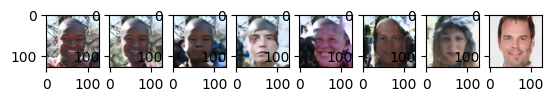

In [65]:
plot_images2(log)

In [102]:
#interpolated results
samples = []
for i in tqdm(range(0, 8)):
    x,_ = next(train_iterator)
    x = x.to(device)
    
    log, _ = t_model.interpolation(x[0][None])
    log = list(log.values())

    for a in log:
        samples.append(a[0].detach())
        

100%|██████████| 8/8 [01:43<00:00, 12.92s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


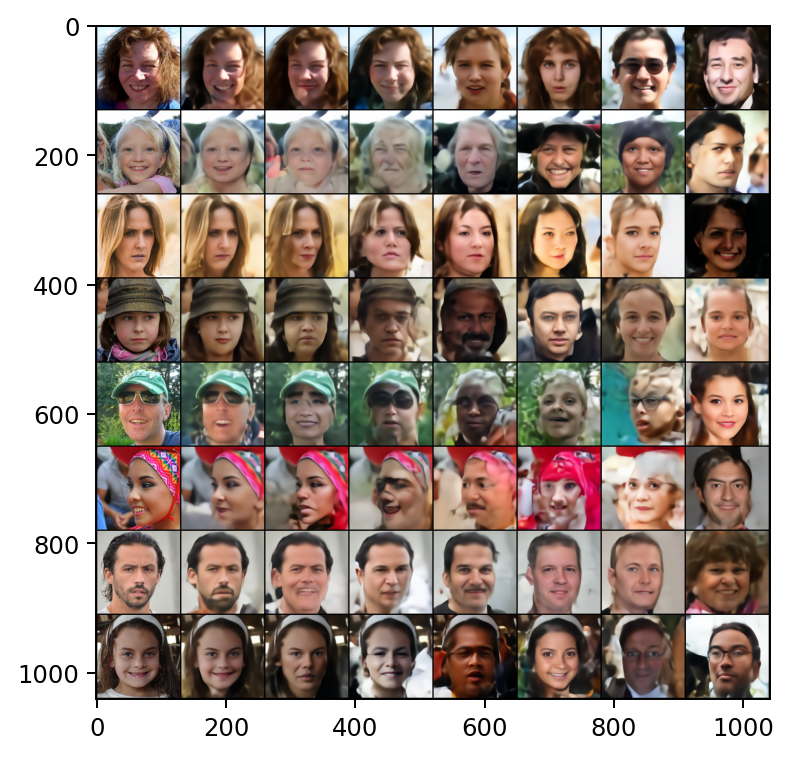

In [103]:
#plot interpolated results
plt.rcParams['figure.dpi'] = 175
plt.rcParams["figure.figsize"] = (5,5)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(samples).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
#generate non cherry picked samples
samples = []
for i in tqdm(range(0, 64)):

    start = torch.empty((1,256), dtype=torch.int64).to("cuda")[:, :0]
    
    sos_tokens = torch.ones(1, 1) * 0
    sos_tokens = sos_tokens.long().to("cuda")
    
    sample_indices = t_model.sample(start, sos_tokens, steps=256)
    sample = t_model.z_to_image(sample_indices)
    samples.append(sample[0].detach())

In [ ]:
#plot non cherry picked samples
plt.rcParams['figure.dpi'] = 175
plt.rcParams["figure.figsize"] = (5,5)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(samples).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
#select best samples
top_4 = []
top_4.append(samples[0])
top_4.append(samples[1])
top_4.append(samples[24])
top_4.append(samples[61])

In [ ]:
#plot best samples
plt.rcParams['figure.dpi'] = 175
plt.rcParams["figure.figsize"] = (6,1)
plt.imshow(samples[26].cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()